# Task 2: RNN application -- Tweet Sentiment Analysis

In [20]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [21]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

<span style="color:red">__TODO:__</span> Below, we've defined the network for you. Please read the code carefully to make sure you understand it. Then, please write a training function to train this network. The settings are:

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional).

In [22]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [23]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [24]:
# Training function
num_steps = train_tweets.shape[0]//batch_size
mean_loss = 0
tot_loss=0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start = step*batch_size 
        end = start + batch_size

        batch_tweet = train_tweets[start:end]
        batch_label = train_labels[start:end]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict={tweets:batch_tweet,labels:batch_label})
        tot_loss+=train_loss
        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                l = i*batch_size
                r = l + batch_size
                test_X = test_tweets[l:r]
                test_Y = test_labels[l:r]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                mean_loss=tot_loss/(step+1)
            print("Iteration number : ",step, " Mean Loss: ", mean_loss, " testing accuracy = ",(test_acc/test_batches))
            
        #print("Mean Loss : ", mean_loss/1000)
            

Iteration number :  0 Mean Loss:  0.693360686302  testing accuracy =  0.532291666667
Iteration number :  50 Mean Loss:  0.68313164337  testing accuracy =  0.627083333333
Iteration number :  100 Mean Loss:  0.643465700126  testing accuracy =  0.676041666667
Iteration number :  150 Mean Loss:  0.617159659894  testing accuracy =  0.698958333333
Iteration number :  200 Mean Loss:  0.60127362861  testing accuracy =  0.7125
Iteration number :  250 Mean Loss:  0.590777170254  testing accuracy =  0.727083333333
Iteration number :  300 Mean Loss:  0.584309775766  testing accuracy =  0.73125
Iteration number :  350 Mean Loss:  0.576578340979  testing accuracy =  0.704166666667
Iteration number :  400 Mean Loss:  0.568356958559  testing accuracy =  0.742708333333
Iteration number :  450 Mean Loss:  0.564199525871  testing accuracy =  0.740625
Iteration number :  500 Mean Loss:  0.560384570779  testing accuracy =  0.732291666667
Iteration number :  550 Mean Loss:  0.557162492981  testing accuracy 

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

<span style="color:red">__TODO:__</span> Define this double-layer LSTM in the below notebook cell. You can copy the single-layer network code and make changes to it. After that, train the network using the function you just wrote.

Hint: Use **tf.contrib.rnn.MultiRNNCell**. You'll find there are only 2-3 lines of code that need to be changed.

In [27]:
# YOUR DOUBLE-LAYER LSTM Here
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
num_layers = 2


# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
# lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)
lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(hidden_size) for i in range(num_layers)])

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1][-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)


In [26]:
# YOUR TRAINING HERE
num_steps = train_tweets.shape[0]//batch_size
tot_loss = 0
mean_loss = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start = step*batch_size
        end = start + batch_size
                
        batch_tweet = train_tweets[start:end]
        batch_label = train_labels[start:end]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict={tweets:batch_tweet,labels:batch_label})
        tot_loss += train_loss
        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                l = i*batch_size
                r = l + batch_size
                test_X = test_tweets[l:r]
                test_Y = test_labels[l:r]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                mean_loss=tot_loss/(step+1)
            print("Iteration Number: ",step, " Mean Loss: ", mean_loss, " Test Accuracy = ",(test_acc/test_batches))

Iteration Number:  0  Mean Loss:  0.69279718399  Test Accuracy =  0.552083333333
Iteration Number:  50  Mean Loss:  0.664740937598  Test Accuracy =  0.644791666667
Iteration Number:  100  Mean Loss:  0.63041769514  Test Accuracy =  0.68125
Iteration Number:  150  Mean Loss:  0.605996398539  Test Accuracy =  0.704166666667
Iteration Number:  200  Mean Loss:  0.59195337085  Test Accuracy =  0.723958333333
Iteration Number:  250  Mean Loss:  0.582227251919  Test Accuracy =  0.738541666667
Iteration Number:  300  Mean Loss:  0.576615548906  Test Accuracy =  0.746875
Iteration Number:  350  Mean Loss:  0.569018911772  Test Accuracy =  0.733333333333
Iteration Number:  400  Mean Loss:  0.561159860686  Test Accuracy =  0.753125
Iteration Number:  450  Mean Loss:  0.556766644748  Test Accuracy =  0.738541666667
Iteration Number:  500  Mean Loss:  0.553454817234  Test Accuracy =  0.744791666667
Iteration Number:  550  Mean Loss:  0.550589983833  Test Accuracy =  0.748958333333
Iteration Number:

## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

<span style="color:red">__TODO:__</span> Take a look at the website above, and write a function to do the embedding. The website itself is a very good tutorial.

Hint: Use **tf.nn.embedding_lookup**

In [30]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    embedding_mat = tf.Variable(tf.random_uniform([vocab_size, output_size], -1.0, 1.0),name = name)
    embed_lookup = tf.nn.embedding_lookup(embedding_mat, input_)
    return embedding_mat,embed_lookup
# YOUR CODE HERE

### Train a single lstm network with embedding layer

<span style="color:red">__TODO:__</span> Build a single-layer LSTM network according to the network structure. Then, train the network with the training function you wrote.

In [31]:
# YOUR EMBEDDING SINGLE-LAYER LSTM HERE
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
output_size = 150


# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

embedding_mat, lookup = embedding(tweets,vocab_size,output_size,'embedding_mat')

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, lookup, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [32]:
# YOUR TRAINING HERE
num_steps = train_tweets.shape[0] // batch_size
tot_loss = 0
mean_loss = 0


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start_idx = step*batch_size
        end_idx = start_idx + batch_size
        

        batchX = train_tweets[start_idx:end_idx]
        batchY = train_labels[start_idx:end_idx]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict= \
                                                {tweets:batchX,labels:batchY})
        tot_loss += train_loss

        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                idx1 = i*batch_size
                idx2 = idx1 + batch_size
                test_X = test_tweets[idx1:idx2]
                test_Y = test_labels[idx1:idx2]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                mean_loss = tot_loss/(step + 1)
            print("Iteration number: ",step, " Mean Loss:", mean_loss, " test accuracy = ",(test_acc/test_batches))
            # TODO: get test accuracy and loss, and print them out.
    vocab_embeddings = sess.run(embedding_mat)

Iteration number:  0  Mean Loss: 0.706552147865  test accuracy =  0.532291666667
Iteration number:  50  Mean Loss: 0.693815140163  test accuracy =  0.565625
Iteration number:  100  Mean Loss: 0.691397750732  test accuracy =  0.575
Iteration number:  150  Mean Loss: 0.681914166504  test accuracy =  0.633333333333
Iteration number:  200  Mean Loss: 0.668290365988  test accuracy =  0.676041666667
Iteration number:  250  Mean Loss: 0.65675956652  test accuracy =  0.670833333333
Iteration number:  300  Mean Loss: 0.648023337423  test accuracy =  0.703125
Iteration number:  350  Mean Loss: 0.635689856235  test accuracy =  0.698958333333
Iteration number:  400  Mean Loss: 0.625751283549  test accuracy =  0.705208333333
Iteration number:  450  Mean Loss: 0.61731521326  test accuracy =  0.725
Iteration number:  500  Mean Loss: 0.610176857063  test accuracy =  0.735416666667
Iteration number:  550  Mean Loss: 0.604033557073  test accuracy =  0.747916666667
Iteration number:  600  Mean Loss: 0.59

### Visualize word vectors via tSNE

<span style="color:red">__TODO:__</span>

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


Hint: You can use **TSNE** tool provided in **scikit-learn**. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., **conda install nomkl numpy scipy scikit-learn numexpr**. 

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [33]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
#fruit_clour = ["apple", "red", "lemon", "yellow", "mandarin", "orange"]

vocab_embeddings.shape

(7597, 150)

In [34]:
from sklearn.manifold import TSNE
### your code here
X_embedded = TSNE( n_components=2, init='pca', n_iter=1000, random_state=10).fit_transform(vocab_embeddings)
X_embedded.shape

(7597, 2)

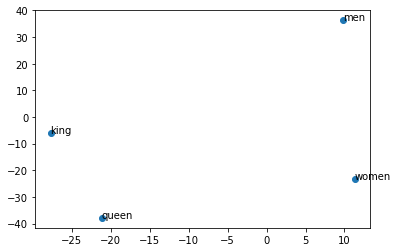

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def wordvec(vocab,words):
    idx = [np.where(vocab==a) for a in words]
    res = []
    for i in range(len(idx)):
        res.append(idx[i][0][0])
    return res
X = X_embedded[wordvec(vocabulary,female_male)]

plt.scatter(X[:,0],X[:,1])

for i, txt in enumerate(female_male):
    plt.annotate(txt, (X[i,0],X[i,1]))
plt.show()



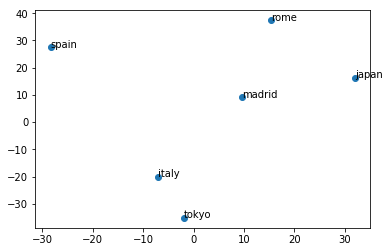

In [36]:
X = X_embedded[wordvec(vocabulary,country_capital)]

plt.scatter(X[:,0],X[:,1])

for i, txt in enumerate(country_capital):
    plt.annotate(txt, (X[i,0],X[i,1]))
plt.show()

#### <span style="color:red">TODO: </span> describe your observation of these word vectors

Answer: **The vector from king to men is roughly parallel to the vector from queen to women. Same is true for the vectors from italy to rome and japan to tokyo. However, the spain-madrid vector seems to be randomly oriented **